# ORIE 4580/5580 Assignment 6

#### Students: Sikai Shen (ss2725) and Franklin Deng (td268)

### Github link: 


### Instructions


* Due Tuesday, November 14, at 11.59am on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

[Mor Harchol-Balter's chapter](https://canvas.cornell.edu/courses/56826/files/9180297/download?download_frd=1) on the Poisson process (on Canvas)

In [1]:
import numpy as np
from numpy.random import choice

from scipy.integrate import quad
from scipy.stats import uniform, poisson, expon
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt

___
___

# Question 1: Everyone goes to Gimme! (25 points)

The downtown Ithaca Gimme! store sees a Poisson arrival process with rate

$$ \lambda(t)=\frac{1}{56}\left(5t^3-90t^2+300t+1480\right) \quad \text{for } 0 \leq t \leq 12,$$

over the 12 hours on the weekdays it is open.


___

**(a)** Compute the exact probability that the coffee store will see more than 250 customers in one 12 hour day. Do not use simulation.
___


## Ans.
The probablity is extremely close to 1

In [2]:
def rate_function(t):
    return (1/56) * (5*t**3 - 90*t**2 + 300*t + 1480)

m_numerical, _ = quad(rate_function, 0, 12)

probability_exact_more_than_250_numerical = poisson.sf(250, m_numerical)
probability_exact_more_than_250_numerical

0.24711253205956527

___

**(b)** Use thinning to simulate 500 replications of the Poisson arrival process. Based on these replications, estimate the probability in Part (a) and report a 95\% confidence interval.

___

## Ans.



In [3]:
def neg_rate_function(t):
    return -rate_function(t)  
result = minimize_scalar(neg_rate_function, bounds=(0, 12), method='bounded')
lambda_max = -result.fun

lambda_max

31.428571428571352

In [4]:
num_simulations = 500

def simulate_thinning(lambda_max, rate_function, time_period, threshold):
    num_events = poisson.rvs(mu=lambda_max * time_period)
    times = uniform.rvs(0, time_period, size=num_events)
    thinned_events = [time for time in times if uniform.rvs(0, 1) <= rate_function(time) / lambda_max]
    return len(thinned_events) > threshold

exceeds_threshold_simulations = [simulate_thinning(lambda_max, rate_function, 12, 250) for _ in range(num_simulations)]
estimated_probability = np.mean(exceeds_threshold_simulations)

standard_error = np.std(exceeds_threshold_simulations, ddof=1) / np.sqrt(num_simulations)
confidence_interval = [estimated_probability - 1.96 * standard_error, estimated_probability + 1.96 * standard_error]

estimated_probability, confidence_interval

(0.258, [0.2196100449009769, 0.2963899550990231])

___
**(c)** Based on your 500 replications, make a bar plot showing the average number of customers who arrive during each of the twelve hours of operation. Plot the rate function $\lambda(t)$ and compare.
___

## Ans.

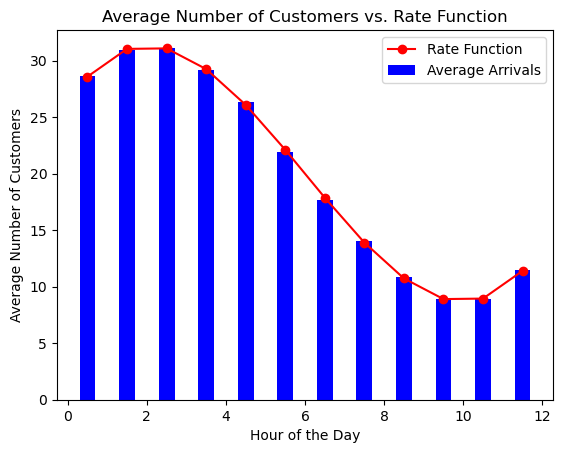

In [5]:
time_periods = np.arange(0, 12, 1)
hourly_arrivals = np.zeros((num_simulations, len(time_periods)))

for i in range(num_simulations):
    num_events = poisson.rvs(mu=lambda_max * 12)
    times = uniform.rvs(0, 12, size=num_events)
    for j, hour in enumerate(time_periods):
        hour_end = hour + 1
        thinned_events = [time for time in times if hour <= time < hour_end and uniform.rvs() <= rate_function(time) / lambda_max]
        hourly_arrivals[i, j] = len(thinned_events)

average_hourly_arrivals = np.mean(hourly_arrivals, axis=0)

def average_rate_for_hour(hour):
    avg_rate, _ = quad(rate_function, hour, hour+1)
    return avg_rate

average_hourly_rates = np.array([average_rate_for_hour(hour) for hour in time_periods])

plt.bar(time_periods + 0.5, average_hourly_arrivals, width=0.4, label='Average Arrivals', color='blue', align='center')
plt.plot(time_periods + 0.5, average_hourly_rates, label='Rate Function', color='red', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Customers')
plt.title('Average Number of Customers vs. Rate Function')
plt.legend()
plt.show()




---
---


# Question 2: Putting my son to bed (30 points)

Sid uses a Spotify playlist with $n$ soothing songs to put his son to sleep. He plays the playlist on shuffle, but is worried that some songs may not get played (he spent a long time curating the playlist!).

___
**(a)**
Suppose Spotify truly picks a random song each time -- Sid wants to know how many songs it takes on average to play **every song** on his playlist. Build a simulator to estimate this for a different values of $n$, and use this to try and guess the function.

*Note: Try and pick a large range of $n$ to get a sense of the function of number of songs needed to play all vs. $n$ -- if you are adventurous, try to fit the function. Make sure you always show your CIs!*
___

## Ans.

The function is n times the harmonic series of n, which can be approximated by n * ln(n). The proof is simple as we consider the sum of expectation of geometric distribution conditioned on number of songs heard.

In [43]:
def simulate_playlist(n, num_simulations=10000):
    total_songs_played = 0
    for _ in range(num_simulations):
        played_songs = set()
        songs_played = 0
        while len(played_songs) < n:
            song = choice(n)
            played_songs.add(song)
            songs_played += 1
        total_songs_played += songs_played
    return total_songs_played / num_simulations

n_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
simulation_results = {n: simulate_playlist(n) for n in n_values}
simulation_results

{5: 11.5022,
 10: 29.2061,
 20: 72.1615,
 30: 119.2517,
 40: 171.4636,
 50: 224.9592,
 60: 280.5484,
 70: 339.1696,
 80: 398.3586,
 90: 457.2789,
 100: 518.857}

___

**(b)** On the other hand, Sid has realized that his son wakes up whenever he hears a song that has been played before (clever, isn't he!). Use your previous simulator to figure out how many songs Sid's son hears before he wakes up.

___

## Ans.



In [44]:
def simulate_playlist_until_repeat(n, num_simulations=10000):
    total_songs_played = 0
    for _ in range(num_simulations):
        played_songs = set()
        songs_played = 0
        while True:
            song = choice(n)
            songs_played += 1
            if song in played_songs:
                break
            else:
                played_songs.add(song)
        total_songs_played += songs_played
    return total_songs_played / num_simulations

simulation_results_until_repeat = {n: simulate_playlist_until_repeat(n) for n in n_values}
simulation_results_until_repeat

{5: 3.4999,
 10: 4.6831,
 20: 6.3609,
 30: 7.5547,
 40: 8.5549,
 50: 9.5085,
 60: 10.4722,
 70: 11.168,
 80: 11.9949,
 90: 12.7042,
 100: 13.2409}

___

**(c)** Suppose Spotify uses the following poor randomizer: it labels songs as $\{0,1,2,\ldots,n-1\}$, and after playing a song $i$, it then either plays song $(i+1) mod(n)$ or $(i-1)mod(n)$ with probability $1/2$ (i.e., the next or previous song, imagining the songs to be in a ring with $n-1$ wrapping around to $1$). Simulate this randomizer for $n=20$, assuming you always start at song $1$, and find the histogram of the **last song to be played** for the first time using this shuffler.   

___

## Ans.

A classic uniform distribution.

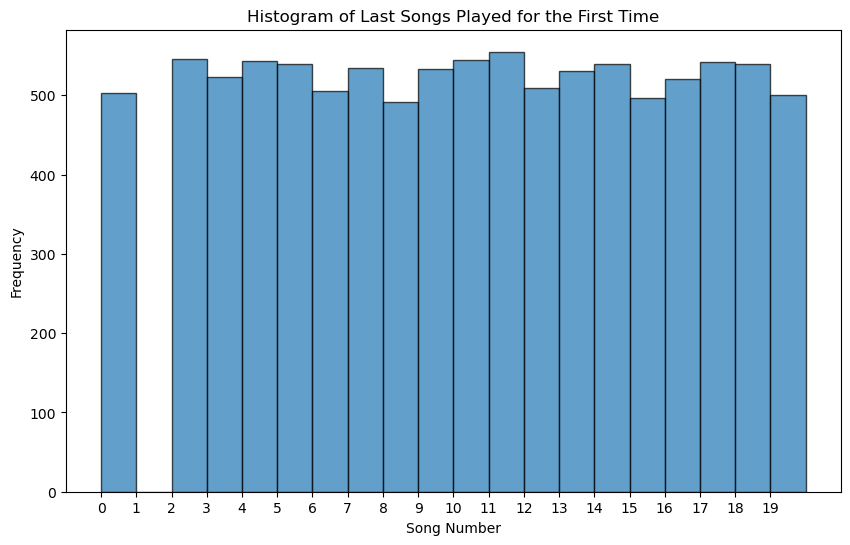

In [22]:
def simulate_poor_randomizer(n, num_simulations=10000):
    last_songs = []
    for _ in range(num_simulations):
        played_songs = set()
        current_song = 1
        played_songs.add(current_song)
        while len(played_songs) < n:
            if np.random.rand() < 0.5:
                current_song = (current_song + 1) % n
            else:
                current_song = (current_song - 1) % n
            if current_song not in played_songs:
                played_songs.add(current_song)
                if len(played_songs) == n:
                    last_songs.append(current_song)
    return last_songs

n = 20
last_songs_played = simulate_poor_randomizer(n)
plt.figure(figsize=(10, 6))
plt.hist(last_songs_played, bins=n, alpha=0.7, edgecolor='black', range=(0,n))
plt.title('Histogram of Last Songs Played for the First Time')
plt.xlabel('Song Number')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, n, 1))
plt.show()

___

**(d) (OPTIONAL)** For the above three questions, try and analytically derive the functions that you should get (and compare)

___
___

# Question 3: The gambler's ruin (20 points)

The gambler's ruin is one of the most famous and widely studied models in stochastic processes. Imagine two gamblers $A$ and $B$ are playing a tournament, where they each start with $a$ and $b$ initially, and play a sequence of games, where each game is won by either player with probability $1/2$, with the winner giving $1$ to the loser. Play goes on till one player runs out of money.

___

**(a)** Simulate this model to find the probability that player $A$ wins the overall tournament. Also, try and derive this analytically, and see how well the two match up.

___

## Ans.

The probability of A winning is $\frac{a}{a+b}$. A more rigorously way to show it is using martingale. Since it's a fair game, the expectation of the money for each player is constant. For player A, it starts with $a$ and ends with either $a+b$ or 0. By setting up the expectation we can get the probability of A winning is $\frac{a}{a+b}$. The sim also matches the result.

In [39]:
def simulate_gamblers_ruin(a, b):
    fortune_a = a
    fortune_b = b
    while fortune_a > 0 and fortune_b > 0:
        if np.random.rand() < 0.5:
            fortune_a += 1
            fortune_b -= 1
        else:
            fortune_a -= 1
            fortune_b += 1
    return fortune_a > 0

def estimate_probability(a, b, num_simulations=10000):
    wins_a = sum(simulate_gamblers_ruin(a, b) for _ in range(num_simulations))
    return wins_a / num_simulations

a = 10
b = 20
num_simulations = 10000
estimated_probability_a_wins = estimate_probability(a, b, num_simulations)
analytical_probability_a_wins = a / (a + b)
estimated_probability_a_wins, analytical_probability_a_wins

(0.3303, 0.3333333333333333)

___
**(b)** Another question we can ask is how long it takes for the tournament to end. To study this, simulate the gambler's ruin for a range of values of $a$ and $b$, and use this to try and guess the expected time to ruin.

*Hint: Convince yourself that the function must be symmetric in $a$ and $b$, so you can assume $a\leq b$. Try plotting the expected absorption times for selected values of $a$, while varying $b$.*

___

## Ans.

The guess from the simulation is $ab$. A more rigorously way to show it is using martingale. Consider $X_{N}^2 - N$, since for any value $a$, we have $\frac{(a+1)^2 + (a-1)^2}{2} - a^2 = 1$, hence we can prove $X_{N}^2 - N$ is a martingale using induction. Then use part (a) and only consider the money of player A. $E(X_{N}^2 - N) = E(X_{N}^2) - E(N) = \frac{a}{a+b} (a+b)^2 - E(N) = a^2 + ab - E(N) = E(X_{0}^2) = a^2$

Hence $E(N) = ab$

In [42]:
def simulate_gamblers_ruin_duration(a, b):
    fortune_a = a
    fortune_b = b
    num_games = 0  
    while fortune_a > 0 and fortune_b > 0:
        num_games += 1
        if np.random.rand() < 0.5:
            fortune_a += 1
            fortune_b -= 1
        else:
            fortune_a -= 1
            fortune_b += 1
    return num_games

def estimate_expected_duration(a_values, b_values, num_simulations=4000):
    duration_results = {}
    for a in a_values:
        for b in b_values:
            total_duration = sum(simulate_gamblers_ruin_duration(a, b) for _ in range(num_simulations))
            average_duration = total_duration / num_simulations
            duration_results[(a, b)] = average_duration
    
    return duration_results

a_values = range(4, 5)
b_values = range(4, 20)
expected_duration_results = estimate_expected_duration(a_values, b_values)
expected_duration_results

{(4, 4): 16.094,
 (4, 5): 19.73325,
 (4, 6): 24.2435,
 (4, 7): 28.52225,
 (4, 8): 32.623,
 (4, 9): 36.1205,
 (4, 10): 38.5715,
 (4, 11): 43.3095,
 (4, 12): 48.371,
 (4, 13): 52.729,
 (4, 14): 56.2825,
 (4, 15): 60.96525,
 (4, 16): 62.746,
 (4, 17): 69.80875,
 (4, 18): 69.9605,
 (4, 19): 77.48325}

___
___

# Question 4: Simulation assigments take forever (25 points)

You are convinced that Simulation homeworks take the longest time compared to all other assignments, while Sid maintains that all assignment times are identically distributed. To decide this debate once and for all, you decide to record how long it takes you to do your assignment, and then survey your friends on how long it took them to do their last assignment until you find someone who took longer$\ldots$

___

**(a)**
Suppose Sid is right (!) and all assignment completion times are truly identically distributed. Formally suppose your own assignment takes time (in hours) distributed as $T_0\sim Exp(0.5)$, and similarly the $i^{th}$ friend you survey also takes time $T_i\sim Exp(0.5)$, independent of all other friends. Run 100 simulations and report a $95\%$ CI for the expected number of friends you need to survey to find someone who takes longer.
___


## Ans.


In [28]:
def simulate_survey(num_simulations=100):
    num_friends_needed = []
    for _ in range(num_simulations):
        your_time = expon(scale=2).rvs()
        friends_times = 0
        number_of_friends = 0
        while friends_times <= your_time:
            friends_times = expon(scale=2).rvs()
            number_of_friends += 1
        num_friends_needed.append(number_of_friends)
    return num_friends_needed

num_simulations = 100
survey_results = simulate_survey(num_simulations)

average_friends_needed = np.mean(survey_results)
std_error = np.std(survey_results, ddof=1) / np.sqrt(num_simulations)
confidence_interval = (average_friends_needed - 1.96 * std_error,
                       average_friends_needed + 1.96 * std_error)
average_friends_needed, confidence_interval

(6.34, (2.1950908832324645, 10.484909116767536))

___

**(b)** You are concerned that the CI looks a little wide, so decide to do more replications to fix the problem. Repeat the above simulation with number of replications $n\in\{100,500,1000,1500,2000,2500,\ldots,9500,10000\}$, and plot the estimates and $95\%$ CIs.
___

## Ans.


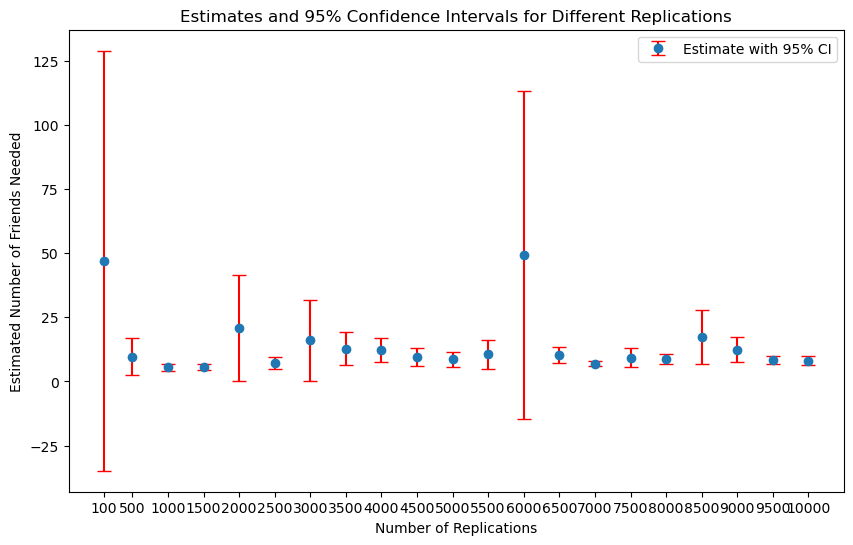

In [33]:
def calculate_confidence_interval(survey_results):
    average_friends_needed = np.mean(survey_results)
    std_error = np.std(survey_results, ddof=1) / np.sqrt(len(survey_results))
    confidence_interval = (average_friends_needed - 1.96 * std_error,
                           average_friends_needed + 1.96 * std_error)
    return average_friends_needed, confidence_interval

replications = np.insert(np.arange(500, 10500, 500), 0, 100)
estimates_and_cis = {}

for n in replications:
    survey_results = simulate_survey(n)
    estimates_and_cis[n] = calculate_confidence_interval(survey_results)

averages = [estimates_and_cis[n][0] for n in replications]
lower_cis = [estimates_and_cis[n][1][0] for n in replications]
upper_cis = [estimates_and_cis[n][1][1] for n in replications]

plt.figure(figsize=(10, 6))
plt.errorbar(replications, averages, yerr=[np.array(averages)-np.array(lower_cis), 
                                            np.array(upper_cis)-np.array(averages)], 
             fmt='o', ecolor='r', capsize=5, label='Estimate with 95% CI')
plt.xlabel('Number of Replications')
plt.ylabel('Estimated Number of Friends Needed')
plt.title('Estimates and 95% Confidence Intervals for Different Replications')
plt.xticks(replications)
plt.legend()
plt.show()

In [36]:
# hardcode the prev result for time saving
estimates_and_cis_result = {100: (47.05, (-34.77222744190941, 128.8722274419094)),
 500: (9.636, (2.5254069687793193, 16.74659303122068)),
 1000: (5.538, (4.13758437117295, 6.938415628827051)),
 1500: (5.568, (4.503150191428205, 6.632849808571795)),
 2000: (20.716, (0.009923654531565518, 41.42207634546844)),
 2500: (7.284, (4.996478811543112, 9.571521188456888)),
 3000: (16.053, (0.36409069936781613, 31.741909300632187)),
 3500: (12.72, (6.340950564268698, 19.099049435731303)),
 4000: (12.22075, (7.467066439947328, 16.974433560052674)),
 4500: (9.463777777777779, (5.846325242712032, 13.081230312843525)),
 5000: (8.7148, (5.819223019351245, 11.610376980648756)),
 5500: (10.558727272727273, (5.009313149130744, 16.108141396323802)),
 6000: (49.13733333333333, (-14.721983164645387, 112.99664983131206)),
 6500: (10.164615384615384, (7.076724123082288, 13.25250664614848)),
 7000: (6.972142857142857, (5.918234332431258, 8.026051381854456)),
 7500: (9.326, (5.464551750839716, 13.187448249160285)),
 8000: (8.656375, (6.761493212572244, 10.551256787427757)),
 8500: (17.322470588235294, (6.643081952882008, 28.001859223588582)),
 9000: (12.41, (7.456656108908252, 17.36334389109175)),
 9500: (8.391263157894738, (6.694840070676534, 10.087686245112941)),
 10000: (8.0831, (6.290003136258072, 9.876196863741928))}

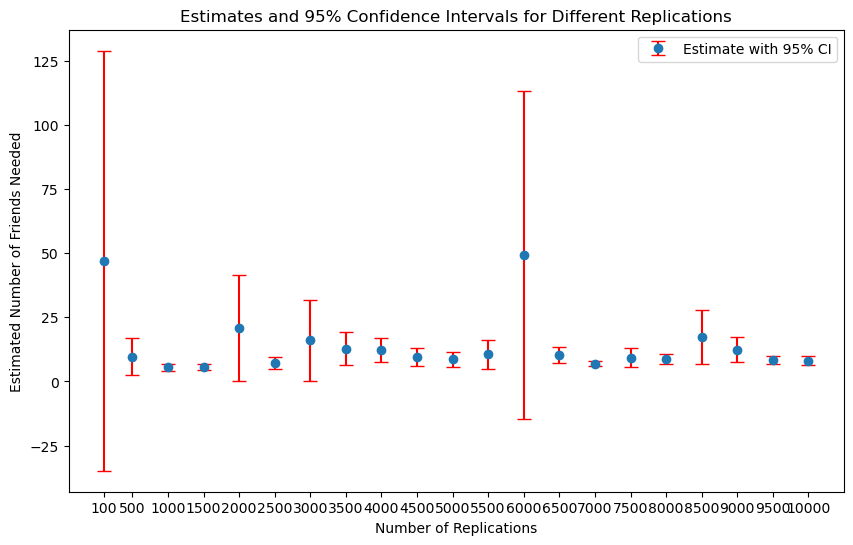

In [37]:
averages = [estimates_and_cis_result[n][0] for n in replications]
lower_cis = [estimates_and_cis_result[n][1][0] for n in replications]
upper_cis = [estimates_and_cis_result[n][1][1] for n in replications]

plt.figure(figsize=(10, 6))
plt.errorbar(replications, averages, yerr=[np.array(averages)-np.array(lower_cis), 
                                            np.array(upper_cis)-np.array(averages)], 
             fmt='o', ecolor='r', capsize=5, label='Estimate with 95% CI')
plt.xlabel('Number of Replications')
plt.ylabel('Estimated Number of Friends Needed')
plt.title('Estimates and 95% Confidence Intervals for Different Replications')
plt.xticks(replications)
plt.legend()
plt.show()

___
**(c)** Hopefully you found the previous part a little surprising(?) Why is that the case? Well, this question highlights an important aspect of simulation that we have taken for granted in past problems -- in order to get an estimator for an unknown quantity, we *need that quantity to be finite*! Find an expression for computing the expected number of queries till we get one which is larger in the above setting, and argue that it is infinite.

*Hint: Remember how we used linearity of expectation and indicator random variables before? Try doing the same, with indicator variables for the $i^{th}$ person (for each $i\in\{1,2,\ldots\}$) being the first person surveyed who took longer than you).*
___


## Ans.

Consider a simple case, for a uniformly distribution $U[0,1]$. Assume we select $x$ (which is the time we spend for ourselves on the homework), then the probability of greater than $x$ is $1 - x$. Consider a geometric distribution with $p = 1-x$, the expectation of that distribution is $\frac{1}{1-x}$, and this geometric distribution can be interpreted as number of friends I need to sample to get someone greater than me.

Therefore, the total expectation of number of people need can be intepreted as following integral

$\int_{0}^{1} \frac{1}{1-x} \, dx$

This integral diverges. Hence the expectation DNE (or not finite).

Now consider the general case, as we studied before, $F^{-1}(X)$ follows a $U[0,1]$, and for exponential distrbution, we clearly have $F^{-1}(X_1) < F^{-1}(X_2)$ iff $X_1 < X_2$. So in this case, the uniform distribution proof can generalize to any continous variable. Let $f(x)$ be the pdf of any continous distribution with support on all non-negative number, the expectation would be

$\int_{0}^{\infty} \frac{f(x)}{1-F(x)} \, dx$

which trivially diverges by FTC.